In [91]:
import uuid, sys, os
import pandas as pd
pd.set_option("display.max_columns", None)   # show all columns
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()
import training_utils.partitioning_utils as pat_utils
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

Tesla V100-SXM2-32GB


### Loading and wrangling data

In [29]:
cols = [
    "Target",
    "DesignName",
    "Trajectory",
    "Binding",
    "Affinity_nM",
    "Length",
    "Sequence",
    "Average_pLDDT",
    "Average_pTM",
    "Average_i_pTM",
    "Average_pAE",
    "Average_i_pAE",
    "Average_i_pLDDT",
    "Average_ss_pLDDT",
    "Average_Unrelaxed_Clashes",
    "Average_Relaxed_Clashes",
    "Average_Binder_Energy_Score",
    "Average_Surface_Hydrophobicity",
    "Average_ShapeComplementarity",
    "Average_PackStat",
    "Average_dG",
    "Average_dSASA",
    "Average_dG/dSASA",
    "Average_Interface_SASA_%",
    "Average_Interface_Hydrophobicity",
    "Average_n_InterfaceResidues",
    "Average_n_InterfaceHbonds",
    "Average_InterfaceHbondsPercentage",
    "Average_n_InterfaceUnsatHbonds",
    "Average_InterfaceUnsatHbondsPercentage",
    "Average_Interface_Helix%",
    "Average_Interface_BetaSheet%",
    "Average_Interface_Loop%",
    "Average_Binder_Helix%",
    "Average_Binder_BetaSheet%",
    "Average_Binder_Loop%",
    "Average_InterfaceAAs",
    "Average_Hotspot_RMSD",
    "Average_Target_RMSD",
    "Average_Binder_pLDDT",
    "Average_Binder_pTM",
    "Average_Binder_pAE",
    "Average_Binder_RMSD"
]

In [30]:
bindcraft_df = pd.read_csv("/work3/s232958/data/bindcraft/bindcraft.csv")
bindcraft_df = bindcraft_df[cols].rename(columns ={
    "Target" : "target_id",
    "DesignName" : "binder_id",
    "Binding" : "binder_label",
    "Length" : "len_seq_binder",
    "Sequence" : "seq_binder"
})

bindcraft_df

,target_id,binder_id,Trajectory,binder_label,Affinity_nM,len_seq_binder,seq_binder,Average_pLDDT,Average_pTM,Average_i_pTM,Average_pAE,Average_i_pAE,Average_i_pLDDT,Average_ss_pLDDT,Average_Unrelaxed_Clashes,Average_Relaxed_Clashes,Average_Binder_Energy_Score,Average_Surface_Hydrophobicity,Average_ShapeComplementarity,Average_PackStat,Average_dG,Average_dSASA,Average_dG/dSASA,Average_Interface_SASA_%,Average_Interface_Hydrophobicity,Average_n_InterfaceResidues,Average_n_InterfaceHbonds,Average_InterfaceHbondsPercentage,Average_n_InterfaceUnsatHbonds,Average_InterfaceUnsatHbondsPercentage,Average_Interface_Helix%,Average_Interface_BetaSheet%,Average_Interface_Loop%,Average_Binder_Helix%,Average_Binder_BetaSheet%,Average_Binder_Loop%,Average_InterfaceAAs,Average_Hotspot_RMSD,Average_Target_RMSD,Average_Binder_pLDDT,Average_Binder_pTM,Average_Binder_pAE,Average_Binder_RMSD
0,BBF-14,BBF_b1,BBF-14_l188_s8417_mpnn3,NaN,NaN,188,MVQDIVDEFRMMLELSRHYPNHFGIGLLYVGWRLVEMLFKERKVSK...,0.94,0.91,0.89,0.11,0.15,0.94,0.95,3.5,0.0,-540.89,0.26,0.73,0.64,-62.84,2054.11,-3.06,23.83,53.33,22.5,6.0,26.68,2.0,8.79,94.74,0.00,5.26,85.64,0.00,14.36,"{'A': 0.0, 'C': 0.0, 'D': 2.5, 'E': 4.0, 'F': ...",1.01,1.35,0.95,0.90,0.10,0.85
1,BBF-14,BBF_b2,BBF-14_l111_s53550_mpnn4,1.0,NaN,111,SNSEKVKSEVKWLKFVIDQILAIRDAKGITDEAAQNAFLERAAPMI...,0.94,0.90,0.87,0.12,0.15,0.95,0.94,3.0,0.0,-305.61,0.32,0.68,0.56,-42.31,1565.88,-2.70,27.58,63.89,18.0,4.0,21.98,1.0,5.57,90.91,0.00,9.09,85.59,0.00,14.41,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 1.5, 'F': ...",1.02,1.60,0.94,0.85,0.10,0.83
2,BBF-14,BBF_b3,BBF-14_l164_s2681_mpnn2,1.0,NaN,164,SELEEKLKKAAEEISEEALKLAEEGKKETEPYKALVEAFEYALEKM...,0.95,0.90,0.86,0.11,0.15,0.94,0.96,3.0,0.0,-449.96,0.30,0.63,0.57,-62.47,2149.50,-2.90,28.05,48.00,25.0,5.0,19.71,2.5,9.93,91.10,0.00,8.89,89.32,0.00,10.68,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 4.0, 'F': ...",1.42,1.61,0.96,0.89,0.09,0.89
3,BBF-14,BBF_b4,BBF-14_l140_s83316_mpnn7,1.0,20.9,140,SPIQEEIQKKVRELLEKLIEYLEELKEKAKPPFKEKLEEVIEGLER...,0.90,0.86,0.84,0.15,0.20,0.92,0.92,3.0,0.0,-418.31,0.29,0.67,0.62,-52.95,1666.34,-3.18,23.20,60.98,20.5,8.0,39.28,2.5,12.26,23.21,65.48,11.31,64.29,14.29,21.43,"{'A': 0.0, 'C': 0.0, 'D': 0.5, 'E': 2.0, 'F': ...",1.59,1.42,0.92,0.84,0.11,1.37
4,BBF-14,BBF_b5,BBF-14_l145_s38796_mpnn9,0.0,NaN,145,LYEEFKKLYEEFLRIGMEAMIKLQEGYASGDREDEELHEEIVKLLK...,0.95,0.89,0.83,0.11,0.15,0.94,0.96,1.5,0.0,-439.61,0.32,0.66,0.66,-61.98,2064.12,-3.01,30.86,71.11,22.5,5.0,22.32,2.5,11.01,93.94,0.00,6.06,84.83,0.00,15.17,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.21,1.69,0.97,0.91,0.08,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,HER2,HER2_b6,HER2_NC_D1_l96_s70660_mpnn6,NaN,NaN,96,NPVIERMIKNIRHAIEIMRRHPGNYRVKLPEIPEVKEYIEEYGSEE...,0.93,0.92,0.88,0.15,0.17,0.89,0.94,3.5,0.0,-285.16,0.34,0.60,0.56,-52.47,2037.49,-2.58,41.09,NaN,26.0,7.5,28.84,3.0,11.54,29.68,21.63,48.69,66.67,4.17,29.17,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 1.0, 'F': ...",1.66,0.94,0.91,0.64,0.16,1.35
208,HER2,HER2_b7,HER2_NC_D1_l97_s46993_mpnn2,NaN,NaN,97,ARPPATMIVGGIWPEDPEERRKKWELVVDHFVEMVAETPEEAEARR...,0.81,0.91,0.81,0.23,0.26,0.84,0.82,0.0,0.5,-250.75,0.32,0.72,0.55,-48.78,1495.65,-3.26,28.58,NaN,20.0,10.5,52.51,1.0,5.01,36.39,42.47,21.14,46.91,28.87,24.23,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.99,0.92,0.85,0.65,0.18,1.43
209,HER2,HER2_b8,HER2_NC_D1_l89_s53772_mpnn1,NaN,NaN,89,SEIEERYKKLLEEVVEFLEKLYKELGEEERIEPLREKLSKLSPSGQ...,0.93,0.91,0.82,0.17,0.20,0.90,0.93,11.0,0.0,-252.19,0.28,0.66,0.62,-45.36,1601.49,-2.84,30.53,NaN,19.5,5.5,28.02,3.0,15.39,100.00,0.00,0.00,91.01,0.00,8.99,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 1.0, 'F': ...",2.35,0.93,0.95,0.80,0.13,2.26
210,HER2,HER2_b9,HER2_NC_D1_l92_s80406_mpnn1,NaN,NaN,92,MEKSEDEKILDTMIKYTGKELVEKAKKLWKEFRKKHGLKAQPRTDE...,0.86,0.90,0.78,0.22,0.24,0.84,0.88,4.5,1.0,-254.17,0.33,0.71,0.55,-52.39,1746.65,-3.00,32.9

In [31]:
bindcraft_df.target_id.unique()

array(['BBF-14', 'BetV1', 'CbAgo', 'CD45', 'CLDN1', 'DerF7', 'DerF21',
       'IFNAR2', 'PD-L1', 'Sas6', 'SpCas9', 'PD1', 'HER2'], dtype=object)

#### Supplementary Tables
##### Supplementary Table 1 | Input structures, hotspot settings, and binder lengths utilized for binder design.
"https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-025-09429-6/MediaObjects/41586_2025_9429_MOESM1_ESM.pdf" page 12

| Target        | Input PDB                                                                                   | Hotspots                                 | Binder length |
|---------------|----------------------------------------------------------------------------------------------|-------------------------------------------|----------------|
| PD-1          | AF2 prediction, trimmed to 32–146                                                            | 64, 126, 129, 133                         | 80–150         |
| PD-L1         | AF2 prediction, trimmed to 18–132                                                            | 54, 56, 66, 115                           | 65–155         |
| IFNAR2        | 2LAG, trimmed to 8–110                                                                       | 52, 80, 82, 84, 96, 98                    | 60–175         |
| CD45          | AF2 prediction of 5FMV, split by extracellular fibronectin domains                           | d1, d2, d3, d4, d1–d2, d2–d3, d3–d4        | 80–200         |
| Claudin1      | AF2 prediction of CLN1–147                                                                   | 31, 46, 55, 152                           | 80–175         |
| BBF-14        | 9HAG                                                                                         | None                                      | 70–250         |
| CrSAS-6       | AF2 prediction, trimmed to 15–160                                                            | None                                      | 90–200         |
| Der f7        | AF2 prediction with 3UV1 template                                                            | 132 or 178 or 201                         | 70–185         |
| Der f21       | AF2 dimer prediction with 5YNY template, trimmed to 25–136                                   | 34 or 52 or 87 or 105 or 116              | 70–185         |
| Bet v1        | AF2 prediction                                                                               | 24                                        | 70–185         |
| SpCas9        | AF2 prediction with 4ZT0 template, trimmed to 96–174 + 306–446                               | 360                                       | 70–150         |
| CbAgo         | AF2 prediction with 6QZK template, trimmed to 1–175 + 298–343 + 635–689 (N+PIWI) or 180–276 (PAZ) | 39 (N+PIWI) or 268 (PAZ)                  | 70–160         |
| HER2 (AAV)    | 1N8Z, trimmed to 23–268                                                                      | 170 or 170, 165                           | 60–100         |
| PD-L1 (AAV)   | AF2 prediction, trimmed to 18–132

In [32]:
target_name_sequence = {
    "BBF-14": "MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYTTPDGTTLEATVDLWKDANGVIRYHATYPDGTSADGTLTQLDADTLLATGTYDDGTKYTVTLTRVAPGSGWHHHHHH", # de novo designed beta-barrel
    "BetV1" : "MGVFNYETEATSVIPAARLFKAFILDGDNLFPKVAPQAISSVENIEGNGGPGTIKKISFPEGFPFKYVKDRVDEVDHTNFKYNYSVIEGGPIGDTLEKISNEIKIVATPDGGSILKISNKYHTKGDHEVKAEQVKASKEMGETLLRAVESYLLAHSDAYN", # birch allergen; PDB id was not given in the paper
    "CbAgo": "ANNLTFEAFEGIGQLNELNFYKYRLIGKGQIDNVHQAIWSVKYKLQANNFFKPVFVKGEILYSLDELKVIPEFENVEVILDGNIILSISENTDIYKDVIVFYINNALKNIKDITNYRKYITKNTDEIICKSILTTNLKYQYMKSEKGFKLQRKFKISPVVFRNGKVILYLNCSSDKMDMNYRYQTLKSFVEDIGVIKELNNLHFKNQYYTNFDFMGFESGVIEVKKNIPVKIAKVVGSNICNPIKGSYVLKNDKAFIVTTDIKDGVASPNPLKIEKIEVKKNIPVKIAKVVGSNICNPIKGSYVLKNDKAFIVTTDIKDGVASPNPLKIEK", # multi-domain Argonaute (Ago) nuclease from Clostridium butyricum (CbAgo)
    # "CbAgo_PAZ": "", 
    "DerF7": "DPIHYDKITEEINKAIDDAIAAIEQSETIDPMKVPDHADKFERHVGILDFKGELAMRNIEARGLKQMKRQGDANVKGEEGIVKAHLLIGVHDDIVSMEYDLAYKLGDLHPTTHVISDIQDFVVALSLEIPDEGNITMTSFEVRQFANVVNHIGGLSILDPIFGVLSDVLTAIFQDTVRKEMTKVLAPAFKRELEKN", # dust mite allergen Der f7
    "DerF21": "EDKWRNAFDHMLMEEFEEKMDQIEHGLLMLSEQYKELEKTKSKELKEQILRELTIAENYLRGALKFMQQEAKRTDLNMFERYNFETAVSTIEILVKDLAELAKKVKAVKSDD", # dust mite allergen Der f21
    "CD45": "ETGKPTCDEKYANITVDYLYNKETKLFTAKLNVNENVECGNNTCTNNEVHNLTECKNASVSISHNSCTAPDKTLILDVPPGVEKFQLHDCTQVEKADTTICLKWKNIETFTCDTQNITYRFQCGNMIFDNKEIKLENLEPEHEYKCDSEILYNNHKFTNASKIIKTDFGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDCLNLDKNLIKYDLQNLKPYTKYVLSLHAYIIAKVQRNGSAAMCHFTTKSAPPSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVRNESHKNCDFRVKDLQYSTDYTFKAYFHNGDYPGEPFILHHSTSGTKHHHHHH",
    "CLDN1" : "MANAGLQLLGFILAFLGWIGAIVSTALPQWRIYSYAGDNIVTAQAMYEGLWMSCVSQSTGQIQCKVFDSLLNLSSTLQATRALMVVGILLGVIAIFVATVGMKCMKCLEDDEVQKMRMAVIGGAIFLLAGLAILVATAWYGNRIVQEFYDPMTPVNARYEFGQALFTGWAAASLCLLGGALLCCSCPRKTTSYPTPRPYPKPAPSSGKDYV", # O95832 · CLD1_HUMAN
    "IFNAR2": "TDESCTFKISLRNFRSILSWELKNHSIVPTHYTLLYTIMSKPEDLKVVKNCANTTRSFCDLTDEWRSTHEAYVTVLEGFSGNTTLFSCSHNFWLAIDMSFEPP",
    "PD-L1" : "AFTITVSKDLYVVEYGSNVTLECRFPVDKQLNLLVLVVYWEMEDKKIIQFVNGKEDPNVQHSSYHGRAQLLKDQLFLGKAALQITDVKLQDAGVYCCLISYGGADYKRITLKVNA",
    "Sas6" : "GFDLSTATTLFWRPVPVHVKQQDREDVLEELTFRILTGVAKQNHNLRILRIHISSDSDLFFLHTLEVSEEDFQSLKNDQGILVDFASFPGKIISLLEKCILAQPGDSPRFQAVLTIRGGESVFKIVEINDFKQLPHITLAFRPGND",
    "HER2": "LRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQVRQVPLQRLRIVRGTQLFEDNYALAVLDNGDPLNNTTPVTGASPGGLRELQLRSLTEILKGGVLIQRNPQLCYQDTILWKDIFHKNNQLALTLIDTNRSRACHPCSPMCKGSRCWGESSEDCQSLTRTVCAGGCARCKGPLPTDCCHEQCAAGCTGPKHSDCLACLHFNHSGICELHCPALVTYNTDTFESMPNPEGRYT",
    "SpCas9": "SFFHRLEESFLVEEDKKHERHPIFGNIVDEVAYHEKYPTIYHLRKKLVDSTDKADLRLIYLALAHMIKFRGHFLIEGDLRVNTEITKAPLSASMIKRYDEHHQDLTLLKALVRQQLPEKYKEIFFDQSKNGYAGYIDGGASQEEFYKFIKPILEKMDGTEELLVKLNREDLLRKQRTFDNGSIPHQIHLGELHAILRRQEDFYPFLKDNREKIEKILT",
    "PD1" : "LPDVPESFVLNWYRVSPRNQTDKLAAFQENHTEPGKDRRFRVTRLPSGQDFHTTILAAQLNDSGIYLCGAIYLPPNTQIYESPRAELTVKERVLEPPTESPSPPPRLTGQGQGL",
}

In [33]:
target_seq = []
for __, row in bindcraft_df.iterrows():
    target_name = row.target_id
    target_seq.append(target_name_sequence[target_name])

bindcraft_df["seq_target"] = target_seq
bindcraft_df["len_seq_target"] = [len(seq) for seq in bindcraft_df["seq_target"]]
bindcraft_df

,target_id,binder_id,Trajectory,binder_label,Affinity_nM,len_seq_binder,seq_binder,Average_pLDDT,Average_pTM,Average_i_pTM,Average_pAE,Average_i_pAE,Average_i_pLDDT,Average_ss_pLDDT,Average_Unrelaxed_Clashes,Average_Relaxed_Clashes,Average_Binder_Energy_Score,Average_Surface_Hydrophobicity,Average_ShapeComplementarity,Average_PackStat,Average_dG,Average_dSASA,Average_dG/dSASA,Average_Interface_SASA_%,Average_Interface_Hydrophobicity,Average_n_InterfaceResidues,Average_n_InterfaceHbonds,Average_InterfaceHbondsPercentage,Average_n_InterfaceUnsatHbonds,Average_InterfaceUnsatHbondsPercentage,Average_Interface_Helix%,Average_Interface_BetaSheet%,Average_Interface_Loop%,Average_Binder_Helix%,Average_Binder_BetaSheet%,Average_Binder_Loop%,Average_InterfaceAAs,Average_Hotspot_RMSD,Average_Target_RMSD,Average_Binder_pLDDT,Average_Binder_pTM,Average_Binder_pAE,Average_Binder_RMSD,seq_target,len_seq_target
0,BBF-14,BBF_b1,BBF-14_l188_s8417_mpnn3,NaN,NaN,188,MVQDIVDEFRMMLELSRHYPNHFGIGLLYVGWRLVEMLFKERKVSK...,0.94,0.91,0.89,0.11,0.15,0.94,0.95,3.5,0.0,-540.89,0.26,0.73,0.64,-62.84,2054.11,-3.06,23.83,53.33,22.5,6.0,26.68,2.0,8.79,94.74,0.00,5.26,85.64,0.00,14.36,"{'A': 0.0, 'C': 0.0, 'D': 2.5, 'E': 4.0, 'F': ...",1.01,1.35,0.95,0.90,0.10,0.85,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122
1,BBF-14,BBF_b2,BBF-14_l111_s53550_mpnn4,1.0,NaN,111,SNSEKVKSEVKWLKFVIDQILAIRDAKGITDEAAQNAFLERAAPMI...,0.94,0.90,0.87,0.12,0.15,0.95,0.94,3.0,0.0,-305.61,0.32,0.68,0.56,-42.31,1565.88,-2.70,27.58,63.89,18.0,4.0,21.98,1.0,5.57,90.91,0.00,9.09,85.59,0.00,14.41,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 1.5, 'F': ...",1.02,1.60,0.94,0.85,0.10,0.83,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122
2,BBF-14,BBF_b3,BBF-14_l164_s2681_mpnn2,1.0,NaN,164,SELEEKLKKAAEEISEEALKLAEEGKKETEPYKALVEAFEYALEKM...,0.95,0.90,0.86,0.11,0.15,0.94,0.96,3.0,0.0,-449.96,0.30,0.63,0.57,-62.47,2149.50,-2.90,28.05,48.00,25.0,5.0,19.71,2.5,9.93,91.10,0.00,8.89,89.32,0.00,10.68,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 4.0, 'F': ...",1.42,1.61,0.96,0.89,0.09,0.89,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122
3,BBF-14,BBF_b4,BBF-14_l140_s83316_mpnn7,1.0,20.9,140,SPIQEEIQKKVRELLEKLIEYLEELKEKAKPPFKEKLEEVIEGLER...,0.90,0.86,0.84,0.15,0.20,0.92,0.92,3.0,0.0,-418.31,0.29,0.67,0.62,-52.95,1666.34,-3.18,23.20,60.98,20.5,8.0,39.28,2.5,12.26,23.21,65.48,11.31,64.29,14.29,21.43,"{'A': 0.0, 'C': 0.0, 'D': 0.5, 'E': 2.0, 'F': ...",1.59,1.42,0.92,0.84,0.11,1.37,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122
4,BBF-14,BBF_b5,BBF-14_l145_s38796_mpnn9,0.0,NaN,145,LYEEFKKLYEEFLRIGMEAMIKLQEGYASGDREDEELHEEIVKLLK...,0.95,0.89,0.83,0.11,0.15,0.94,0.96,1.5,0.0,-439.61,0.32,0.66,0.66,-61.98,2064.12,-3.01,30.86,71.11,22.5,5.0,22.32,2.5,11.01,93.94,0.00,6.06,84.83,0.00,15.17,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.21,1.69,0.97,0.91,0.08,0.90,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,HER2,HER2_b6,HER2_NC_D1_l96_s70660_mpnn6,NaN,NaN,96,NPVIERMIKNIRHAIEIMRRHPGNYRVKLPEIPEVKEYIEEYGSEE...,0.93,0.92,0.88,0.15,0.17,0.89,0.94,3.5,0.0,-285.16,0.34,0.60,0.56,-52.47,2037.49,-2.58,41.09,NaN,26.0,7.5,28.84,3.0,11.54,29.68,21.63,48.69,66.67,4.17,29.17,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 1.0, 'F': ...",1.66,0.94,0.91,0.64,0.16,1.35,LRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQV...,245
208,HER2,HER2_b7,HER2_NC_D1_l97_s46993_mpnn2,NaN,NaN,97,ARPPATMIVGGIWPEDPEERRKKWELVVDHFVEMVAETPEEAEARR...,0.81,0.91,0.81,0.23,0.26,0.84,0.82,0.0,0.5,-250.75,0.32,0.72,0.55,-48.78,1495.65,-3.26,28.58,NaN,20.0,10.5,52.51,1.0,5.01,36.39,42.47,21.14,46.91,28.87,24.23,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.99,0.92,0.85,0.65,0.18,1.43,LRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQV...,245
209,HER2,HER2_b8,HER2_NC_D1_l89_s53772_mpnn1,NaN,NaN,89,SEIEERYKKLLEEVVEFLEKLYKELGEEERIEPLREKLSKLSPSGQ...,0.93,0.91,0.82,0.17,0.2

In [36]:
cols = list(bindcraft_df.columns)
move_cols = ["seq_target", "len_seq_target"]
for c in move_cols:
    cols.remove(c)

insert_after = cols.index("seq_binder") + 1

for i, c in enumerate(move_cols):
    cols.insert(insert_after + i, c)

bindcraft_df = bindcraft_df[cols]
bindcraft_df

,target_id,binder_id,Trajectory,binder_label,Affinity_nM,len_seq_binder,seq_binder,seq_target,len_seq_target,Average_pLDDT,Average_pTM,Average_i_pTM,Average_pAE,Average_i_pAE,Average_i_pLDDT,Average_ss_pLDDT,Average_Unrelaxed_Clashes,Average_Relaxed_Clashes,Average_Binder_Energy_Score,Average_Surface_Hydrophobicity,Average_ShapeComplementarity,Average_PackStat,Average_dG,Average_dSASA,Average_dG/dSASA,Average_Interface_SASA_%,Average_Interface_Hydrophobicity,Average_n_InterfaceResidues,Average_n_InterfaceHbonds,Average_InterfaceHbondsPercentage,Average_n_InterfaceUnsatHbonds,Average_InterfaceUnsatHbondsPercentage,Average_Interface_Helix%,Average_Interface_BetaSheet%,Average_Interface_Loop%,Average_Binder_Helix%,Average_Binder_BetaSheet%,Average_Binder_Loop%,Average_InterfaceAAs,Average_Hotspot_RMSD,Average_Target_RMSD,Average_Binder_pLDDT,Average_Binder_pTM,Average_Binder_pAE,Average_Binder_RMSD
0,BBF-14,BBF_b1,BBF-14_l188_s8417_mpnn3,NaN,NaN,188,MVQDIVDEFRMMLELSRHYPNHFGIGLLYVGWRLVEMLFKERKVSK...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.94,0.91,0.89,0.11,0.15,0.94,0.95,3.5,0.0,-540.89,0.26,0.73,0.64,-62.84,2054.11,-3.06,23.83,53.33,22.5,6.0,26.68,2.0,8.79,94.74,0.00,5.26,85.64,0.00,14.36,"{'A': 0.0, 'C': 0.0, 'D': 2.5, 'E': 4.0, 'F': ...",1.01,1.35,0.95,0.90,0.10,0.85
1,BBF-14,BBF_b2,BBF-14_l111_s53550_mpnn4,1.0,NaN,111,SNSEKVKSEVKWLKFVIDQILAIRDAKGITDEAAQNAFLERAAPMI...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.94,0.90,0.87,0.12,0.15,0.95,0.94,3.0,0.0,-305.61,0.32,0.68,0.56,-42.31,1565.88,-2.70,27.58,63.89,18.0,4.0,21.98,1.0,5.57,90.91,0.00,9.09,85.59,0.00,14.41,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 1.5, 'F': ...",1.02,1.60,0.94,0.85,0.10,0.83
2,BBF-14,BBF_b3,BBF-14_l164_s2681_mpnn2,1.0,NaN,164,SELEEKLKKAAEEISEEALKLAEEGKKETEPYKALVEAFEYALEKM...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.90,0.86,0.11,0.15,0.94,0.96,3.0,0.0,-449.96,0.30,0.63,0.57,-62.47,2149.50,-2.90,28.05,48.00,25.0,5.0,19.71,2.5,9.93,91.10,0.00,8.89,89.32,0.00,10.68,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 4.0, 'F': ...",1.42,1.61,0.96,0.89,0.09,0.89
3,BBF-14,BBF_b4,BBF-14_l140_s83316_mpnn7,1.0,20.9,140,SPIQEEIQKKVRELLEKLIEYLEELKEKAKPPFKEKLEEVIEGLER...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.90,0.86,0.84,0.15,0.20,0.92,0.92,3.0,0.0,-418.31,0.29,0.67,0.62,-52.95,1666.34,-3.18,23.20,60.98,20.5,8.0,39.28,2.5,12.26,23.21,65.48,11.31,64.29,14.29,21.43,"{'A': 0.0, 'C': 0.0, 'D': 0.5, 'E': 2.0, 'F': ...",1.59,1.42,0.92,0.84,0.11,1.37
4,BBF-14,BBF_b5,BBF-14_l145_s38796_mpnn9,0.0,NaN,145,LYEEFKKLYEEFLRIGMEAMIKLQEGYASGDREDEELHEEIVKLLK...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.89,0.83,0.11,0.15,0.94,0.96,1.5,0.0,-439.61,0.32,0.66,0.66,-61.98,2064.12,-3.01,30.86,71.11,22.5,5.0,22.32,2.5,11.01,93.94,0.00,6.06,84.83,0.00,15.17,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.21,1.69,0.97,0.91,0.08,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,HER2,HER2_b6,HER2_NC_D1_l96_s70660_mpnn6,NaN,NaN,96,NPVIERMIKNIRHAIEIMRRHPGNYRVKLPEIPEVKEYIEEYGSEE...,LRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQV...,245,0.93,0.92,0.88,0.15,0.17,0.89,0.94,3.5,0.0,-285.16,0.34,0.60,0.56,-52.47,2037.49,-2.58,41.09,NaN,26.0,7.5,28.84,3.0,11.54,29.68,21.63,48.69,66.67,4.17,29.17,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 1.0, 'F': ...",1.66,0.94,0.91,0.64,0.16,1.35
208,HER2,HER2_b7,HER2_NC_D1_l97_s46993_mpnn2,NaN,NaN,97,ARPPATMIVGGIWPEDPEERRKKWELVVDHFVEMVAETPEEAEARR...,LRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQV...,245,0.81,0.91,0.81,0.23,0.26,0.84,0.82,0.0,0.5,-250.75,0.32,0.72,0.55,-48.78,1495.65,-3.26,28.58,NaN,20.0,10.5,52.51,1.0,5.01,36.39,42.47,21.14,46.91,28.87,24.23,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.99,0.92,0.85,0.65,0.18,1.43
209,HER2,HER2_b8,HER2_NC_D1_l89_s53772_mpnn1,NaN,NaN,89,SEIEERYKKLLEEVVEFLEKLYKELGEEERIEPLREKLSKLSPSGQ...,LRHLYQGCQVVQGNLELTYLPTN

In [43]:
interaction_dict = {}
for _, row in bindcraft_df.iterrows():
    tkey = row.target_id
    tseq = row.seq_target
    bkey = row.binder_id
    bseq = row.seq_binder

    interaction_dict[bkey] = bseq
    if tkey not in interaction_dict:
        interaction_dict[tkey] = tseq
interaction_dict["BBF-14"]

'MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYTTPDGTTLEATVDLWKDANGVIRYHATYPDGTSADGTLTQLDADTLLATGTYDDGTKYTVTLTRVAPGSGWHHHHHH'

In [55]:
bindcraft_df.to_csv("/work3/s232958/data/bindcraft/bindcraft_with_target_seq.csv", index = False)

In [102]:
bindcraft_df_filtered = bindcraft_df[~bindcraft_df.binder_label.isna()]

### Remove CbAgo, cause it is not clear which target sequence was used
bindcraft_df_filtered_without_CbAgo = bindcraft_df_filtered[bindcraft_df_filtered.target_id != "CbAgo"]
bindcraft_df_filtered_without_CbAgo

,target_id,binder_id,Trajectory,binder_label,Affinity_nM,len_seq_binder,seq_binder,seq_target,len_seq_target,Average_pLDDT,Average_pTM,Average_i_pTM,Average_pAE,Average_i_pAE,Average_i_pLDDT,Average_ss_pLDDT,Average_Unrelaxed_Clashes,Average_Relaxed_Clashes,Average_Binder_Energy_Score,Average_Surface_Hydrophobicity,Average_ShapeComplementarity,Average_PackStat,Average_dG,Average_dSASA,Average_dG/dSASA,Average_Interface_SASA_%,Average_Interface_Hydrophobicity,Average_n_InterfaceResidues,Average_n_InterfaceHbonds,Average_InterfaceHbondsPercentage,Average_n_InterfaceUnsatHbonds,Average_InterfaceUnsatHbondsPercentage,Average_Interface_Helix%,Average_Interface_BetaSheet%,Average_Interface_Loop%,Average_Binder_Helix%,Average_Binder_BetaSheet%,Average_Binder_Loop%,Average_InterfaceAAs,Average_Hotspot_RMSD,Average_Target_RMSD,Average_Binder_pLDDT,Average_Binder_pTM,Average_Binder_pAE,Average_Binder_RMSD
1,BBF-14,BBF_b2,BBF-14_l111_s53550_mpnn4,1.0,NaN,111,SNSEKVKSEVKWLKFVIDQILAIRDAKGITDEAAQNAFLERAAPMI...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.94,0.90,0.87,0.12,0.15,0.95,0.94,3.0,0.0,-305.61,0.32,0.68,0.56,-42.31,1565.88,-2.70,27.58,63.89,18.0,4.0,21.98,1.0,5.57,90.91,0.00,9.09,85.59,0.00,14.41,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 1.5, 'F': ...",1.02,1.60,0.94,0.85,0.10,0.83
2,BBF-14,BBF_b3,BBF-14_l164_s2681_mpnn2,1.0,NaN,164,SELEEKLKKAAEEISEEALKLAEEGKKETEPYKALVEAFEYALEKM...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.90,0.86,0.11,0.15,0.94,0.96,3.0,0.0,-449.96,0.30,0.63,0.57,-62.47,2149.50,-2.90,28.05,48.00,25.0,5.0,19.71,2.5,9.93,91.10,0.00,8.89,89.32,0.00,10.68,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 4.0, 'F': ...",1.42,1.61,0.96,0.89,0.09,0.89
3,BBF-14,BBF_b4,BBF-14_l140_s83316_mpnn7,1.0,20.9,140,SPIQEEIQKKVRELLEKLIEYLEELKEKAKPPFKEKLEEVIEGLER...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.90,0.86,0.84,0.15,0.20,0.92,0.92,3.0,0.0,-418.31,0.29,0.67,0.62,-52.95,1666.34,-3.18,23.20,60.98,20.5,8.0,39.28,2.5,12.26,23.21,65.48,11.31,64.29,14.29,21.43,"{'A': 0.0, 'C': 0.0, 'D': 0.5, 'E': 2.0, 'F': ...",1.59,1.42,0.92,0.84,0.11,1.37
4,BBF-14,BBF_b5,BBF-14_l145_s38796_mpnn9,0.0,NaN,145,LYEEFKKLYEEFLRIGMEAMIKLQEGYASGDREDEELHEEIVKLLK...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.89,0.83,0.11,0.15,0.94,0.96,1.5,0.0,-439.61,0.32,0.66,0.66,-61.98,2064.12,-3.01,30.86,71.11,22.5,5.0,22.32,2.5,11.01,93.94,0.00,6.06,84.83,0.00,15.17,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.21,1.69,0.97,0.91,0.08,0.90
5,BBF-14,BBF_b6,BBF-14_l70_s2436_mpnn10,1.0,NaN,70,TKWYPVTEENRERFIAFFREMVAIQEDESLSNEEKLERIRELAEKY...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.93,0.86,0.83,0.13,0.16,0.92,0.93,1.0,0.0,-186.82,0.30,0.68,0.67,-55.09,1914.22,-2.88,45.20,60.47,21.5,6.0,28.03,3.0,13.96,62.50,12.50,25.00,73.57,2.86,23.57,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.0, 'F': ...",1.83,1.73,0.92,0.76,0.11,1.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,PD-L1,PD-L1_b200,PDL1_l91_s80587_mpnn3,1.0,NaN,91,SMEEILREKKKKVLEKLKELEKNKDTMSDQEKVNKFGEIHQLIYEM...,AFTITVSKDLYVVEYGSNVTLECRFPVDKQLNLLVLVVYWEMEDKK...,115,0.94,0.89,0.85,0.12,0.15,0.95,0.94,NaN,NaN,-248.24,0.27,0.66,0.63,-56.84,1896.96,-3.00,36.79,48.91,22.5,7.0,30.93,2.0,9.00,91.00,0.00,9.00,76.92,0.00,23.08,"{""A"": 0.0, ""C"": 0.0, ""D"": 1.0, ""E"": 1.0, ""F"": ...",NaN,NaN,0.90,0.79,0.13,2.64
192,PD-L1,PD-L1_b201,PDL1_l101_s58632_mpnn1,1.0,NaN,101,MERKVLHFEGVSEENWEEVLEEVKKKFKEFIEEKGKGPYTVIVMFT...,AFTITVSKDLYVVEYGSNVTLECRFPVDKQLNLLVLVVYWEMEDKK...,115,0.92,0.86,0.81,0.15,0.18,0.93,0.94,NaN,NaN,-338.07,0.32,0.67,0.67,-49.92,1684.49,-2.96,31.07,44.14,20.5,6.5,31.70,2.0,9.81,0.00,97.06,2.94,34.65,36.63,28.71,"{""A"": 0.0, ""C"": 0.0, ""D"": 0.0, ""E"": 3.5, ""F"": ...",NaN,NaN,0.92,0.79,0.12,2.17
193,PD-L1,PD-L1_b202,PDL1_l106_s68831_mpnn3,1.0,NaN,106,SEAEELIEKFKKLLEELVEESKKLGEELLKSIEKNYEKFEELLSKG...,AFTITVSKD

### Grab pretrained PPint model and check on this dataset

In [53]:
def create_key_padding_mask(embeddings, padding_value=0, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input,padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input,padding_value=self.padding_value)
 
        # Initialize residual states
        # pep_emb = pep_input.clone()
        # prot_emb = prot_input.clone()

        pep_emb  = pep_input
        prot_emb = prot_input
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) # Dot-Product for comparison
        
        return logits
    

    def training_step(self, batch, device):
        # Passing the sequences to the models
 
        embedding_pep = batch[0]
        embedding_prot = batch[1]
 
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        positive_logits = self(embedding_pep, embedding_prot)
        
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)

        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        torch.cuda.empty_cache()
        return loss
    
    def validation_step(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep = batch[0]
        embedding_prot = batch[1]
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        with torch.no_grad():

            positive_logits = self(
                    embedding_pep,
                    embedding_prot,
                    # interaction_pep,
                    # interaction_prot,
                    # int_prob = 0.0
                    )
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1) 
            

            negative_logits = self(embedding_pep[rows,:,:], 
                              embedding_prot[cols,:,:], 
                              int_prob=0.0)
                   
            
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
            # partner_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        positive_logits = self(
            embedding_pep,
            embedding_prot)
        
        # Negaive indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) 
        
        negative_logits = self(embedding_pep[rows,:,:], 
                      embedding_prot[cols,:,:], 
                      int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        # Fill diagonal with positive scores
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        return logit_matrix

In [54]:
path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # or model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

In [103]:
class CLIP_boltzgen_dataset(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=1152,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.encoding_path = path

        # lengths
        self.max_blen = self.dframe["len_seq_binder"].max()
        self.max_tlen = self.dframe["len_seq_target"].max()

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESMC embeddings"):
            tgt_id = self.dframe.loc[accession]["target_id"]
            bnd_id = accession
            # lbl = torch.tensor(int(self.dframe.loc[accession, "binder"]))

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb, t_emb = self.samples[idx]
        b_emb, t_emb = torch.from_numpy(b_emb).float(), torch.from_numpy(t_emb).float()
        return b_emb, t_emb

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        return b, t

bindcraft_dataset = CLIP_boltzgen_dataset(bindcraft_df_filtered_without_CbAgo, path = "/work3/s232958/data/bindcraft/embeddings_esmC", embedding_dim=1152)

#Loading ESMC embeddings: 100%|██████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 150.10it/s]


In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bindcraft_loader = DataLoader(bindcraft_dataset, batch_size=20, shuffle=False)

@torch.no_grad()
def run_batch(model, batch, device):
    binders_batch, targets_batch = batch      # unpack
    binders_batch = binders_batch.to(device)
    targets_batch = targets_batch.to(device)
    logits = model(binders_batch, targets_batch)
    return logits

model.to(device)
model.eval()

interaction_scores = []

for batch in tqdm(bindcraft_loader, desc="#Iterating through batched data"):
    logits = run_batch(model, batch, device)
    interaction_scores.append(logits.cpu())

interaction_scores = torch.cat(interaction_scores, dim=0)
interaction_probabilities = [torch.sigmoid(int_score).cpu().numpy() for int_score in interaction_scores]

#Iterating through batched data: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.42it/s]


In [106]:
bindcraft_df_filtered_without_CbAgo["inter_prob"] = interaction_probabilities
bindcraft_df_filtered_without_CbAgo["pred_binder"] = bindcraft_df_filtered_without_CbAgo["inter_prob"] >= 0.5
bindcraft_df_filtered_without_CbAgo["intr_scores"] = interaction_scores
bindcraft_df_filtered_without_CbAgo

/tmp/ipykernel_4092421/529894996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bindcraft_df_filtered_without_CbAgo["inter_prob"] = interaction_probabilities
/tmp/ipykernel_4092421/529894996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bindcraft_df_filtered_without_CbAgo["pred_binder"] = bindcraft_df_filtered_without_CbAgo["inter_prob"] >= 0.5
/tmp/ipykernel_4092421/529894996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,target_id,binder_id,Trajectory,binder_label,Affinity_nM,len_seq_binder,seq_binder,seq_target,len_seq_target,Average_pLDDT,Average_pTM,Average_i_pTM,Average_pAE,Average_i_pAE,Average_i_pLDDT,Average_ss_pLDDT,Average_Unrelaxed_Clashes,Average_Relaxed_Clashes,Average_Binder_Energy_Score,Average_Surface_Hydrophobicity,Average_ShapeComplementarity,Average_PackStat,Average_dG,Average_dSASA,Average_dG/dSASA,Average_Interface_SASA_%,Average_Interface_Hydrophobicity,Average_n_InterfaceResidues,Average_n_InterfaceHbonds,Average_InterfaceHbondsPercentage,Average_n_InterfaceUnsatHbonds,Average_InterfaceUnsatHbondsPercentage,Average_Interface_Helix%,Average_Interface_BetaSheet%,Average_Interface_Loop%,Average_Binder_Helix%,Average_Binder_BetaSheet%,Average_Binder_Loop%,Average_InterfaceAAs,Average_Hotspot_RMSD,Average_Target_RMSD,Average_Binder_pLDDT,Average_Binder_pTM,Average_Binder_pAE,Average_Binder_RMSD,inter_prob,pred_binder,intr_scores
1,BBF-14,BBF_b2,BBF-14_l111_s53550_mpnn4,1.0,NaN,111,SNSEKVKSEVKWLKFVIDQILAIRDAKGITDEAAQNAFLERAAPMI...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.94,0.90,0.87,0.12,0.15,0.95,0.94,3.0,0.0,-305.61,0.32,0.68,0.56,-42.31,1565.88,-2.70,27.58,63.89,18.0,4.0,21.98,1.0,5.57,90.91,0.00,9.09,85.59,0.00,14.41,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 1.5, 'F': ...",1.02,1.60,0.94,0.85,0.10,0.83,0.40457875,False,-0.386423
2,BBF-14,BBF_b3,BBF-14_l164_s2681_mpnn2,1.0,NaN,164,SELEEKLKKAAEEISEEALKLAEEGKKETEPYKALVEAFEYALEKM...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.90,0.86,0.11,0.15,0.94,0.96,3.0,0.0,-449.96,0.30,0.63,0.57,-62.47,2149.50,-2.90,28.05,48.00,25.0,5.0,19.71,2.5,9.93,91.10,0.00,8.89,89.32,0.00,10.68,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 4.0, 'F': ...",1.42,1.61,0.96,0.89,0.09,0.89,0.78522134,True,1.296357
3,BBF-14,BBF_b4,BBF-14_l140_s83316_mpnn7,1.0,20.9,140,SPIQEEIQKKVRELLEKLIEYLEELKEKAKPPFKEKLEEVIEGLER...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.90,0.86,0.84,0.15,0.20,0.92,0.92,3.0,0.0,-418.31,0.29,0.67,0.62,-52.95,1666.34,-3.18,23.20,60.98,20.5,8.0,39.28,2.5,12.26,23.21,65.48,11.31,64.29,14.29,21.43,"{'A': 0.0, 'C': 0.0, 'D': 0.5, 'E': 2.0, 'F': ...",1.59,1.42,0.92,0.84,0.11,1.37,0.4266652,False,-0.295470
4,BBF-14,BBF_b5,BBF-14_l145_s38796_mpnn9,0.0,NaN,145,LYEEFKKLYEEFLRIGMEAMIKLQEGYASGDREDEELHEEIVKLLK...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.89,0.83,0.11,0.15,0.94,0.96,1.5,0.0,-439.61,0.32,0.66,0.66,-61.98,2064.12,-3.01,30.86,71.11,22.5,5.0,22.32,2.5,11.01,93.94,0.00,6.06,84.83,0.00,15.17,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.21,1.69,0.97,0.91,0.08,0.90,0.44234544,False,-0.231649
5,BBF-14,BBF_b6,BBF-14_l70_s2436_mpnn10,1.0,NaN,70,TKWYPVTEENRERFIAFFREMVAIQEDESLSNEEKLERIRELAEKY...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.93,0.86,0.83,0.13,0.16,0.92,0.93,1.0,0.0,-186.82,0.30,0.68,0.67,-55.09,1914.22,-2.88,45.20,60.47,21.5,6.0,28.03,3.0,13.96,62.50,12.50,25.00,73.57,2.86,23.57,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.0, 'F': ...",1.83,1.73,0.92,0.76,0.11,1.26,0.79822266,True,1.375223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,PD-L1,PD-L1_b200,PDL1_l91_s80587_mpnn3,1.0,NaN,91,SMEEILREKKKKVLEKLKELEKNKDTMSDQEKVNKFGEIHQLIYEM...,AFTITVSKDLYVVEYGSNVTLECRFPVDKQLNLLVLVVYWEMEDKK...,115,0.94,0.89,0.85,0.12,0.15,0.95,0.94,NaN,NaN,-248.24,0.27,0.66,0.63,-56.84,1896.96,-3.00,36.79,48.91,22.5,7.0,30.93,2.0,9.00,91.00,0.00,9.00,76.92,0.00,23.08,"{""A"": 0.0, ""C"": 0.0, ""D"": 1.0, ""E"": 1.0, ""F"": ...",NaN,NaN,0.90,0.79,0.13,2.64,0.52683353,True,0.107437
192,PD-L1,PD-L1_b201,PDL1_l101_s58632_mpnn1,1.0,NaN,101,MERKVLHFEGVSEENWEEVLEEVKKKFKEFIEEKGKGPYTVIVMFT...,AFTITVSKDLYVVEYGSNVTLECRFPVDKQLNLLVLVVYWEMEDKK...,115,0.92,0.86,0.81,0.15,0.18,0.93,0.94,NaN,NaN,-338.07,0.32,0.67,0.67,-49.92,1684.49,-2.96,31.07,44.14,20.5,6.5,31.70,2.0,9.81,0.00,97.06,2.94,34.65,36.63,28.71,"{"

,target_id,binder_id,Trajectory,binder_label,Affinity_nM,len_seq_binder,seq_binder,seq_target,len_seq_target,Average_pLDDT,Average_pTM,Average_i_pTM,Average_pAE,Average_i_pAE,Average_i_pLDDT,Average_ss_pLDDT,Average_Unrelaxed_Clashes,Average_Relaxed_Clashes,Average_Binder_Energy_Score,Average_Surface_Hydrophobicity,Average_ShapeComplementarity,Average_PackStat,Average_dG,Average_dSASA,Average_dG/dSASA,Average_Interface_SASA_%,Average_Interface_Hydrophobicity,Average_n_InterfaceResidues,Average_n_InterfaceHbonds,Average_InterfaceHbondsPercentage,Average_n_InterfaceUnsatHbonds,Average_InterfaceUnsatHbondsPercentage,Average_Interface_Helix%,Average_Interface_BetaSheet%,Average_Interface_Loop%,Average_Binder_Helix%,Average_Binder_BetaSheet%,Average_Binder_Loop%,Average_InterfaceAAs,Average_Hotspot_RMSD,Average_Target_RMSD,Average_Binder_pLDDT,Average_Binder_pTM,Average_Binder_pAE,Average_Binder_RMSD,inter_prob,pred_binder,intr_scores
1,BBF-14,BBF_b2,BBF-14_l111_s53550_mpnn4,1.0,NaN,111,SNSEKVKSEVKWLKFVIDQILAIRDAKGITDEAAQNAFLERAAPMI...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.94,0.90,0.87,0.12,0.15,0.95,0.94,3.0,0.0,-305.61,0.32,0.68,0.56,-42.31,1565.88,-2.70,27.58,63.89,18.0,4.0,21.98,1.0,5.57,90.91,0.00,9.09,85.59,0.00,14.41,"{'A': 1.0, 'C': 0.0, 'D': 0.0, 'E': 1.5, 'F': ...",1.02,1.60,0.94,0.85,0.10,0.83,0.40457875,False,-0.386423
2,BBF-14,BBF_b3,BBF-14_l164_s2681_mpnn2,1.0,NaN,164,SELEEKLKKAAEEISEEALKLAEEGKKETEPYKALVEAFEYALEKM...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.90,0.86,0.11,0.15,0.94,0.96,3.0,0.0,-449.96,0.30,0.63,0.57,-62.47,2149.50,-2.90,28.05,48.00,25.0,5.0,19.71,2.5,9.93,91.10,0.00,8.89,89.32,0.00,10.68,"{'A': 1.0, 'C': 0.0, 'D': 1.0, 'E': 4.0, 'F': ...",1.42,1.61,0.96,0.89,0.09,0.89,0.78522134,True,1.296357
3,BBF-14,BBF_b4,BBF-14_l140_s83316_mpnn7,1.0,20.9,140,SPIQEEIQKKVRELLEKLIEYLEELKEKAKPPFKEKLEEVIEGLER...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.90,0.86,0.84,0.15,0.20,0.92,0.92,3.0,0.0,-418.31,0.29,0.67,0.62,-52.95,1666.34,-3.18,23.20,60.98,20.5,8.0,39.28,2.5,12.26,23.21,65.48,11.31,64.29,14.29,21.43,"{'A': 0.0, 'C': 0.0, 'D': 0.5, 'E': 2.0, 'F': ...",1.59,1.42,0.92,0.84,0.11,1.37,0.4266652,False,-0.295470
4,BBF-14,BBF_b5,BBF-14_l145_s38796_mpnn9,0.0,NaN,145,LYEEFKKLYEEFLRIGMEAMIKLQEGYASGDREDEELHEEIVKLLK...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.95,0.89,0.83,0.11,0.15,0.94,0.96,1.5,0.0,-439.61,0.32,0.66,0.66,-61.98,2064.12,-3.01,30.86,71.11,22.5,5.0,22.32,2.5,11.01,93.94,0.00,6.06,84.83,0.00,15.17,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.5, 'F': ...",1.21,1.69,0.97,0.91,0.08,0.90,0.44234544,False,-0.231649
5,BBF-14,BBF_b6,BBF-14_l70_s2436_mpnn10,1.0,NaN,70,TKWYPVTEENRERFIAFFREMVAIQEDESLSNEEKLERIRELAEKY...,MGTPLWALLGGPWRGTATYEDGTKVTLDYRYTRVSPDRLRADVTYT...,122,0.93,0.86,0.83,0.13,0.16,0.92,0.93,1.0,0.0,-186.82,0.30,0.68,0.67,-55.09,1914.22,-2.88,45.20,60.47,21.5,6.0,28.03,3.0,13.96,62.50,12.50,25.00,73.57,2.86,23.57,"{'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 2.0, 'F': ...",1.83,1.73,0.92,0.76,0.11,1.26,0.79822266,True,1.375223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,PD-L1,PD-L1_b200,PDL1_l91_s80587_mpnn3,1.0,NaN,91,SMEEILREKKKKVLEKLKELEKNKDTMSDQEKVNKFGEIHQLIYEM...,AFTITVSKDLYVVEYGSNVTLECRFPVDKQLNLLVLVVYWEMEDKK...,115,0.94,0.89,0.85,0.12,0.15,0.95,0.94,NaN,NaN,-248.24,0.27,0.66,0.63,-56.84,1896.96,-3.00,36.79,48.91,22.5,7.0,30.93,2.0,9.00,91.00,0.00,9.00,76.92,0.00,23.08,"{""A"": 0.0, ""C"": 0.0, ""D"": 1.0, ""E"": 1.0, ""F"": ...",NaN,NaN,0.90,0.79,0.13,2.64,0.52683336,True,0.107437
192,PD-L1,PD-L1_b201,PDL1_l101_s58632_mpnn1,1.0,NaN,101,MERKVLHFEGVSEENWEEVLEEVKKKFKEFIEEKGKGPYTVIVMFT...,AFTITVSKDLYVVEYGSNVTLECRFPVDKQLNLLVLVVYWEMEDKK...,115,0.92,0.86,0.81,0.15,0.18,0.93,0.94,NaN,NaN,-338.07,0.32,0.67,0.67,-49.92,1684.49,-2.96,31.07,44.14,20.5,6.5,31.70,2.0,9.81,0.00,97.06,2.94,34.65,36.63,28.71,"{"

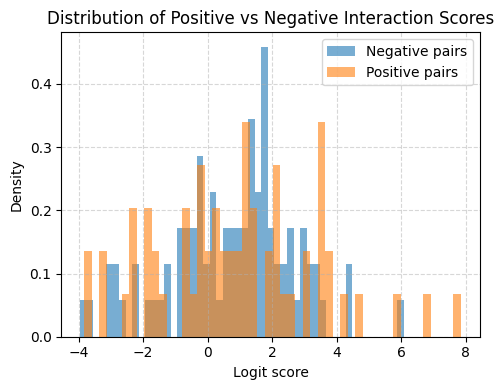

In [107]:
pos_logits, neg_logits = [], []
for __, row in bindcraft_df_filtered_without_CbAgo.iterrows():
    logit = row.intr_scores
    if row.binder_label == False:
        neg_logits.append(logit)
    elif row.binder_label == True:
        pos_logits.append(logit)

plt.figure(figsize=(5, 4))

plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [109]:
labels = torch.as_tensor(bindcraft_df_filtered_without_CbAgo["binder_label"].to_numpy(copy=False), dtype=torch.float32, device=device)
logits = torch.as_tensor(interaction_scores, dtype=torch.float32, device=device)

loss = F.binary_cross_entropy_with_logits(logits, labels)
loss

tensor(1.1844, device='cuda:0')

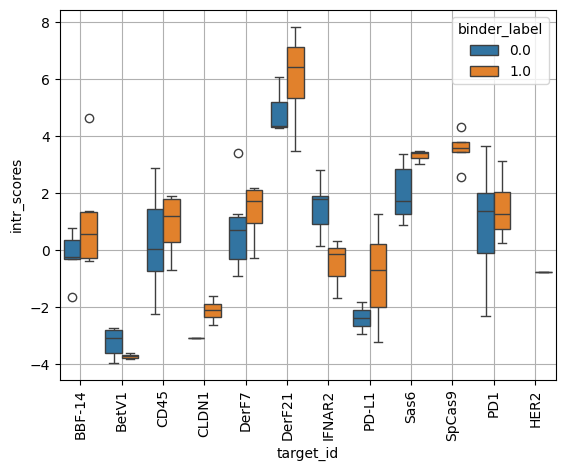

In [110]:
sns.boxplot(data=bindcraft_df_filtered_without_CbAgo, x="target_id", y="intr_scores" ,hue="binder_label",legend=True)
plt.xticks(rotation=90)
plt.grid()
plt.show()

              precision    recall  f1-score   support

         0.0     0.5577    0.3333    0.4173        87
         1.0     0.4082    0.6349    0.4969        63

    accuracy                         0.4600       150
   macro avg     0.4829    0.4841    0.4571       150
weighted avg     0.4949    0.4600    0.4507       150

AUC: 0.509


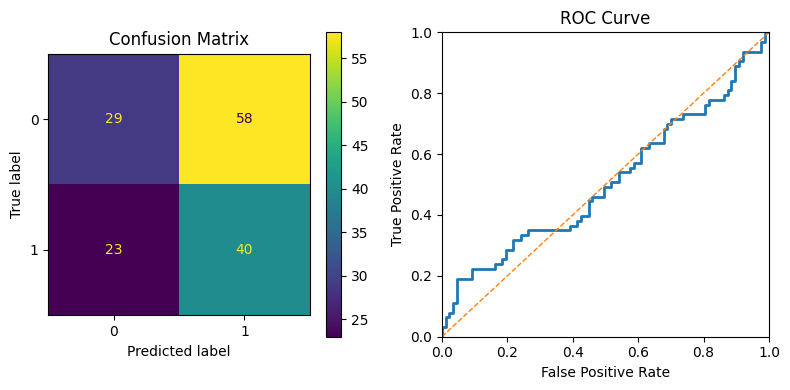

In [111]:
pred_labels = np.array(bindcraft_df_filtered_without_CbAgo.pred_binder)
true_labels = np.array(bindcraft_df_filtered_without_CbAgo["binder_label"])

true_positives = ((pred_labels == 1) & (true_labels == 1)).sum().item()
true_negatives = ((pred_labels == 0) & (true_labels == 0)).sum().item()
false_positives = ((pred_labels == 1) & (true_labels == 0)).sum().item()
false_negatives = ((pred_labels == 0) & (true_labels == 1)).sum().item()

predicted_positives = true_positives + false_positives
all_real_positives = true_positives + false_negatives

print(classification_report(true_labels, pred_labels, digits = 4))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix")

TPR = true_positives / (true_positives + true_negatives) # how good the model is at predicting the positive class when the actual outcome is positive.
# sensitivity = true_positives / (true_positives + false_negatives) # the same as TPR
FPR = false_positives / (false_positives + true_negatives) # how often a positive class is predicted when the actual outcome is negative.
# specificity = true_negatives / (true_negatives + false_positives) # FPR = 1 - specificity

fpr, tpr, thresholds = roc_curve(true_labels, interaction_probabilities)
auc = roc_auc_score(true_labels, interaction_probabilities)
print('AUC: %.3f' % auc)

axes[1].plot(fpr, tpr, linewidth=2)
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # diagonal reference
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve')

# show the plot
plt.tight_layout()
plt.show()

In [ ]:
# scores = {
#     "Interaction prob": np.asarray(boltzgen_df_filtered["inter_prob"]),
#     "boltz_iptm": np.asarray(boltzgen_df_filtered["boltz_iptm"]),
#     "af3_iptm": np.asarray(boltzgen_df_filtered["af3_iptm"]),
# }

# plt.figure(figsize=(6,4))
# for model, values in scores.items():
#     fpr, tpr, _ = sklearn.metrics.roc_curve(true_labels, values)
#     auc = roc_auc_score(true_labels, values)
#     plt.plot(fpr, tpr, linewidth=2, label=f"{model} (AUC={auc:.3f})")

# plt.plot([0,1],[0,1],"--", linewidth=1)
# plt.xlim(0,1); plt.ylim(0,1)
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC curves")
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.show()

In [ ]:
# true_labels
# pred_PPint = np.asarray(boltzgen_df_filtered.inter_prob)
# pred_boltz = np.asarray(boltzgen_df_filtered.boltz_iptm)
# pred_af3 = np.asarray(boltzgen_df_filtered.af3_iptm)

# AP_PPint = average_precision_score(true_labels, pred_PPint)
# AP_af3 = average_precision_score(true_labels, pred_af3)
# AP_boltz = average_precision_score(true_labels, pred_boltz)

# print(f"Average precission of PPint model:{AP_PPint:.4f}")
# print(f"Average precission of AF3 model:{AP_af3:.4f}")
# print(f"Average precission of Boltz model:{AP_boltz:.4f}")

# models = {
#     "PPint": pred_PPint,
#     "AF3":   pred_af3,
#     "Boltz": pred_boltz,
# }

# # Compute and print APs
# print("Average precision (AP):")
# ap_values = {}
# for name, scores in models.items():
#     ap = average_precision_score(true_labels, scores)
#     ap_values[name] = ap
#     print(f"  {name}: {ap:.4f}")

# # Plot PR curves
# plt.figure(figsize=(5,5))

# for name, scores in models.items():
#     precision, recall, _ = precision_recall_curve(true_labels, scores)
#     ap = ap_values[name]
#     plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})", linewidth=2)

# # Baseline = positive class prevalence
# pos_rate = true_labels.mean()
# plt.hlines(pos_rate, 0, 1, linestyles="dashed", label=f"Baseline={pos_rate:.3f}")

# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision–Recall Curves")
# plt.grid(alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()